<h2> 1. Dataset & Dataloader for Audio </h2>

In [25]:
import numpy as np 
import pandas as pd 
import os
import torch
import librosa
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Memory monitor
from my_memory_profiler import profile


In [19]:
# @profile
def label_generator(DATA_PATH_NeuroV):
    data_list = []
    
    for dirname, _, filenames in os.walk(DATA_PATH_NeuroV):
        for filename in filenames:
            if filename.endswith('.wav'):  # Check if the file is a WAV file
                identifiers = filename.split('.')[0].split('_')
                Speaker_ID = int(identifiers[-1])
                Label = 1 if identifiers[0] == 'PD' else 0
                data_list.append({
                    "Speaker_ID": Speaker_ID,
                    "Label": Label,
                    "FileName": filename
                })
    
    data_NeuroV = pd.DataFrame(data_list)
        
    return data_NeuroV

In [15]:
# @profile
def num_seg(data_dir, audio_labels, SAMPLE_RATE, output_csv=None, filenames=False):
    time_leng=0.4
    sample_leng=int(time_leng*SAMPLE_RATE)
    overloap=2
    segments_info=[]
    # audio_labels=pd.read_csv('labels.csv')


    #Processs data to train
    for data_ind, audio_label in enumerate(audio_labels.values):
        file_name=audio_label[-1]
        data_path=os.path.join(data_dir, file_name)
        audio, sample_rate = librosa.load(data_path, sr=SAMPLE_RATE)
        audio_len=len(audio)
        #print(audio_len)
        #plt.plot(audio)
        audio=audio/np.max(abs(audio))
        indx=[i for i,x in enumerate(np.sqrt(abs(audio))) if x>.30]
        segments=0
        if (indx[0]+sample_leng)<audio_len:
            for i in range(int((-indx[0]+indx[len(indx)-1])/(sample_leng/overloap))):
                ind_start = i * int(sample_leng/overloap)+indx[0]
                ind_end = ind_start + sample_leng
                if ind_end <= indx[-1]:
                    segments+=1
            if filenames:
                segments_info.append({
                    'Filename': file_name,
                    'Segments': segments})
            else: 
                segments_info.append({'Segments':segments})
            
            print(" Processed {}/{} files".format(data_ind,2902),end='\n')
        else:
            print(" Processed {}/{} files".format(data_ind,2902),end='\n')
            if filenames:
                segments_info.append({
                    'Filename': file_name,
                    'Segments': segments})
            else: 
                segments_info.append({'Segments':segments})
    

    df_segments = pd.DataFrame(segments_info)
    if(output_csv is None):
        return df_segments
    else:
        df_segments.to_csv(output_csv, index=False)

<h3>Extensión a la DB</h3>

In [20]:
### NUM_SEGMENTOS Y LABEL_GENERATOR
DATA_PATH_NeuroV = 'neurovoz/zenodo_upload/audios/'
SAMPLE_RATE_=44100

audio_labels = label_generator(DATA_PATH_NeuroV)
audio_labels.head()


label_generator: consumed memory: 0.000000 GB


,Speaker_ID,Label,FileName
0,16,1,PD_PERRO_0016.wav
1,143,0,HC_O2_0143.wav
2,78,1,PD_CARMEN_0078.wav
3,81,0,HC_PERRO_0081.wav
4,52,0,HC_PATATA_BLANDA_0052.wav


In [22]:
numero_segmentos=num_seg(DATA_PATH_NeuroV, audio_labels, SAMPLE_RATE_)

 Processed 0/2902 files
 Processed 1/2902 files
 Processed 2/2902 files
 Processed 3/2902 files
 Processed 4/2902 files
 Processed 5/2902 files
 Processed 6/2902 files
 Processed 7/2902 files
 Processed 8/2902 files
 Processed 9/2902 files
 Processed 10/2902 files
 Processed 11/2902 files
 Processed 12/2902 files
 Processed 13/2902 files
 Processed 14/2902 files
 Processed 15/2902 files
 Processed 16/2902 files
 Processed 17/2902 files
 Processed 18/2902 files
 Processed 19/2902 files
 Processed 20/2902 files
 Processed 21/2902 files
 Processed 22/2902 files
 Processed 23/2902 files
 Processed 24/2902 files
 Processed 25/2902 files
 Processed 26/2902 files
 Processed 27/2902 files
 Processed 28/2902 files
 Processed 29/2902 files
 Processed 30/2902 files
 Processed 31/2902 files
 Processed 32/2902 files
 Processed 33/2902 files
 Processed 34/2902 files
 Processed 35/2902 files
 Processed 36/2902 files
 Processed 37/2902 files
 Processed 38/2902 files
 Processed 39/2902 files
 Processed

In [30]:
extension_DB=pd.concat([audio_labels, numero_segmentos], axis=1)

extension_DB.to_csv('extension.csv', index=False)
DATASET_SIZE=extension_DB['Segments'].sum()

extension_DB.head()

,Speaker_ID,Label,FileName,Segments
0,16,1,PD_PERRO_0016.wav,8
1,143,0,HC_O2_0143.wav,20
2,78,1,PD_CARMEN_0078.wav,7
3,81,0,HC_PERRO_0081.wav,7
4,52,0,HC_PATATA_BLANDA_0052.wav,9


In [26]:
# @profile
def process_select_signals(data_path, sample_rate):
    segment_length=0.4
    overlap_factor=2
    amplitude_threshold=0.30
    audio, _ = librosa.load(data_path, sr=sample_rate)
    audio_len = len(audio)
    audio = audio / np.max(np.abs(audio))  # Normalize audio

    time_length = segment_length
    sample_length = int(time_length * sample_rate)
    overlap = overlap_factor

    signals = []
    y_label = []
    subject_group = []

    # Find segments
    indx = [i for i, x in enumerate(np.sqrt(np.abs(audio))) if x > amplitude_threshold]

    segments = 0
    if len(indx) > 0 and (indx[0] + sample_length) < audio_len:
        for i in range(int((-indx[0] + indx[-1]) / (sample_length / overlap))):
            ind_start = i * int(sample_length / overlap) + indx[0]
            ind_end = ind_start + sample_length
            if ind_end <= indx[-1]:
                signal = np.zeros(sample_length)
                signal = audio[ind_start:int(ind_end)]
                signals.append(signal)
                y_label.append('Label')  # Replace 'Label' with actual label assignment logic
                subject_group.append('Speaker_ID')  # Replace 'Speaker_ID' with actual speaker ID assignment logic
                segments += 1

        print(f"Processed audio file: {data_path}")
        print(f"Time audio: {(audio_len - 1) / sample_rate} seconds, Segments: {segments}")
    else:
        print(f"No segments found in audio file: {data_path}")

    signals = np.stack(signals, axis=0) if signals else np.empty((0, sample_length))
    y_label = np.array(y_label)
    subject_group = np.array(subject_group)

    return signals

In [27]:
# @profile
def to_spectrogram(signal, sample_rate):
    n_fft = 2048
    win_length = int(0.015*sample_rate) 
    hop_length = int(0.010*sample_rate)
    n_mels = 65 

    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        onesided=True,
        n_mels=n_mels,
        mel_scale="htk",
    )

    scaler = StandardScaler()
    
    mel_spect = librosa.power_to_db(mel_spectrogram(torch.from_numpy(signal)))
    mel_spect_norm=scaler.fit_transform(mel_spect)
    
    return mel_spect_norm


In [38]:
# params: audio_labels: list of

class CustomAudioDataset(Dataset):

    def __init__(self, extension,  data_dir, sample_rate, to_spectrogram=False):
        
        self.labels=extension['Label'].values
        self.IDs=extension['Speaker_ID'].values
        self.filenames=extension['FileName'].values
        self.num_segs=extension['Segments'].values
        self.spec_id_to_file_id = np.concatenate([np.full(count, idx) for idx, count in enumerate(self.num_segs)])

        # sample rate y path al directorio
        self.sample_rate=sample_rate
        self.data_dir=data_dir

        # to_spectrogram: True or False
        self.to_spectrogram=to_spectrogram

        # cache
        # self.isincache=[]
        # self.cache=[]

        # signal index
        signal_index=[]
        for number in self.num_segs:
            for i in range(number):
                signal_index.append(i)

        self.signal_index=signal_index
        
        
    def __len__(self):

        # numero de segmentos/espectrogramas que puede obtener getitem
        return len(self.spec_id_to_file_id) ### tambien seria sum(self.num_segs)
    
    def __getitem__(self, idx):

        # mapeo de indices: file_index es el que se usa para hacer el fetch al DB. 
        file_index=self.spec_id_to_file_id[idx]

        ### if(file_index in self.isincache): 

        # data_path = directory/path + /filename.wav
        data_path=os.path.join(self.data_dir, self.filenames[file_index]) 

        # audio, sample_rate = librosa.load(data_path, sr=SAMPLE_RATE)
        label=self.labels[file_index]
        subject_group= self.IDs[file_index]

        signals=process_select_signals(data_path, self.sample_rate)
        
        if(self.to_spectrogram):
            audio=to_spectrogram(signals[self.signal_index[idx]], self.sample_rate)
            ### self.cache = [to_spectrogram(sig) for sig in signals_cache]
        else:
            audio=signals[idx]
            ### self.cache=signals
        
        return audio, label, subject_group

Processed audio file: neurovoz/zenodo_upload/audios/HC_ESPONTANEA_0128.wav
Time audio: 79.00888888888889 seconds, Segments: 388
process_select_signals: consumed memory: 0.027283 GB


/home/ivan/anaconda3/envs/gaps/lib/python3.12/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


to_spectrogram: consumed memory: 0.011044 GB
Processed audio file: neurovoz/zenodo_upload/audios/HC_CARMEN_0133.wav
Time audio: 2.036281179138322 seconds, Segments: 6
process_select_signals: consumed memory: 0.000500 GB
to_spectrogram: consumed memory: 0.000759 GB


/home/ivan/anaconda3/envs/gaps/lib/python3.12/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


Processed audio file: neurovoz/zenodo_upload/audios/HC_PATAKA_0122.wav
Time audio: 8.724807256235827 seconds, Segments: 40
process_select_signals: consumed memory: 0.004028 GB
to_spectrogram: consumed memory: 0.000000 GB


/home/ivan/anaconda3/envs/gaps/lib/python3.12/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


Processed audio file: neurovoz/zenodo_upload/audios/HC_ESPONTANEA_0120.wav
Time audio: 39.82340136054422 seconds, Segments: 191
process_select_signals: consumed memory: 0.020477 GB
to_spectrogram: consumed memory: 0.000000 GB


/home/ivan/anaconda3/envs/gaps/lib/python3.12/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


Processed audio file: neurovoz/zenodo_upload/audios/HC_ABLANDADA_0140.wav
Time audio: 5.015487528344671 seconds, Segments: 13
process_select_signals: consumed memory: 0.000000 GB
to_spectrogram: consumed memory: 0.000000 GB


/home/ivan/anaconda3/envs/gaps/lib/python3.12/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


Processed audio file: neurovoz/zenodo_upload/audios/PD_E1_0111.wav
Time audio: 3.5570975056689345 seconds, Segments: 16
process_select_signals: consumed memory: -0.000004 GB
to_spectrogram: consumed memory: 0.000000 GB


/home/ivan/anaconda3/envs/gaps/lib/python3.12/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


Processed audio file: neurovoz/zenodo_upload/audios/HC_O2_0034.wav
Time audio: 6.909954648526077 seconds, Segments: 33
process_select_signals: consumed memory: -0.000031 GB
to_spectrogram: consumed memory: 0.000000 GB


/home/ivan/anaconda3/envs/gaps/lib/python3.12/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


Processed audio file: neurovoz/zenodo_upload/audios/PD_ESPONTANEA_0077.wav
Time audio: 23.70591836734694 seconds, Segments: 115
process_select_signals: consumed memory: 0.000187 GB
to_spectrogram: consumed memory: 0.000000 GB


/home/ivan/anaconda3/envs/gaps/lib/python3.12/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


Processed audio file: neurovoz/zenodo_upload/audios/HC_ESPONTANEA_0034.wav
Time audio: 60.636213151927436 seconds, Segments: 300
process_select_signals: consumed memory: 0.014725 GB
to_spectrogram: consumed memory: 0.000000 GB


/home/ivan/anaconda3/envs/gaps/lib/python3.12/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


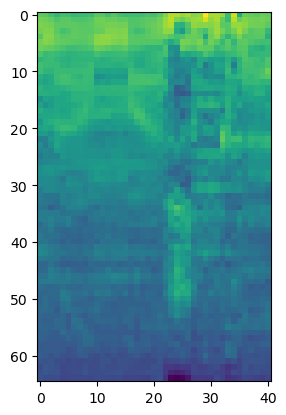

In [39]:
BATCH_SIZE=9
iters=int(DATASET_SIZE/BATCH_SIZE)

#Dataset
datasetAudio = CustomAudioDataset(extension_DB, DATA_PATH_NeuroV, SAMPLE_RATE_, to_spectrogram=True)

#DataLoader
dataloader = DataLoader(datasetAudio, batch_size=BATCH_SIZE, shuffle=True)

spectrogram_batch, label_batch, subject_batch = next(iter(dataloader))

plt.imshow(spectrogram_batch[0])



In [ ]:
for epoch in range(200):

    for i in range(iters):

        spectrogram_batch, label_batch, subject_batch = next(iter(dataloader))

        print

